In [ ]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Using our merged dataset train & test data

This Task is (SEB VS NEVUS). PLEASE USE APPROPRIATE PATH TO TASK

In [ ]:
#please set title for saving model correctly!!!
title = "seb_vs_nev_no_aug"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from vit_keras import vit
import tensorflow_addons as tfa
import math

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
os.listdir('/content')

['.config', 'drive', 'sample_data']

Intializing ViT Model

In [ ]:
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 6s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Adding additional layers to ViT

In [ ]:
# Add additional layers after the Vision Transformer

model = tensorflow.keras.Sequential([
    vit_model,
    Flatten(),
    Dense(128, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(32, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(2, activation='softmax')
], name='vision_transformer')



model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 layer_normalization (LayerN  (None, 128)              256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

#custom function for focal loss
def focal_loss(gamma=2, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        focal_loss = -alpha * y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fn

# Compiling model using adam optimizer and focal loss
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

Configuring early stopping criteria and learning rate

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=8)         # Configuring early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                                          #Configuring learning rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

Function for plotting train and validation accuracy and loss

In [ ]:
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # ROC score calculation

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)

    precision = precision_score(test_labels, predicted_labels, average='weighted')

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Set the directories for the data for task1 (SEB VS NEVUS)
train_dir = "/content/drive/MyDrive/msc_project/train_splited"
test_dir = "/content/drive/MyDrive/msc_project/test_splited"

In [ ]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [ ]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=None)

In [ ]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 1300 validated image filenames belonging to 2 classes.
Found 326 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.7462
Epoch 1: val_accuracy improved from -inf to 0.92500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_1.hdf5
13/13 [==============================] - 141s 6s/step - loss: 0.1695 - accuracy: 0.7462 - val_loss: 0.0881 - val_accuracy: 0.9250 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.8231
Epoch 2: val_accuracy did not improve from 0.92500
13/13 [==============================] - 65s 5s/step - loss: 0.0835 - accuracy: 0.8231 - val_loss: 0.0404 - val_accuracy: 0.8250 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate

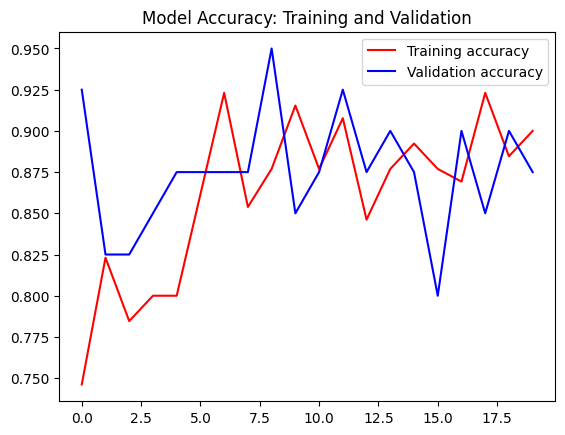

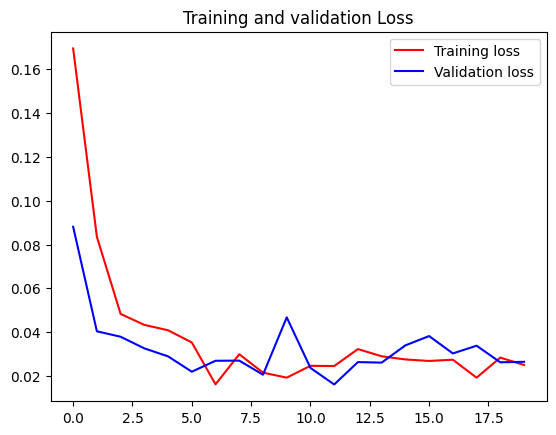

<Figure size 640x480 with 0 Axes>

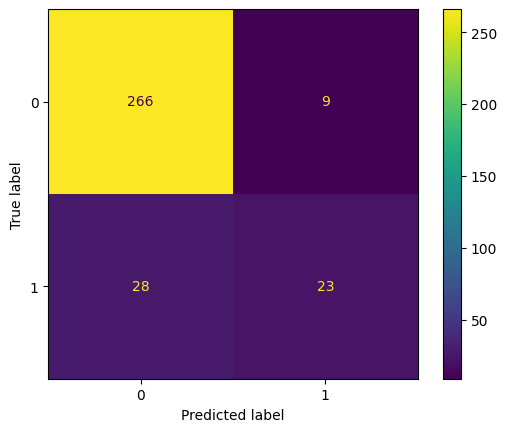


               precision    recall  f1-score   support

           0       0.90      0.97      0.93       275
           1       0.72      0.45      0.55        51

    accuracy                           0.89       326
   macro avg       0.81      0.71      0.74       326
weighted avg       0.88      0.89      0.88       326

Sensitivity: 0.451 Specificity: 0.967 Precision: 0.876 ROC_AUC_SCORE: 0.892



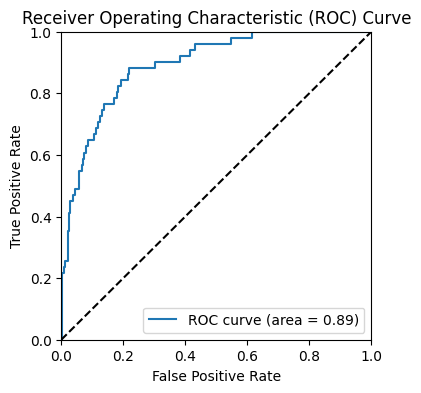

Validation complete...
Traning for Fold: 2
Found 1301 validated image filenames belonging to 2 classes.
Found 325 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.8929
Epoch 1: val_accuracy improved from -inf to 0.82500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_2.hdf5
14/14 [==============================] - 66s 1s/step - loss: 0.0309 - accuracy: 0.8929 - val_loss: 0.0405 - val_accuracy: 0.8250 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.8857
Epoch 2: val_accuracy improved from 0.82500 to 0.87500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_2.hdf5
14/14 [==============================] - 11s 748ms/step - loss: 0.0275 - accura

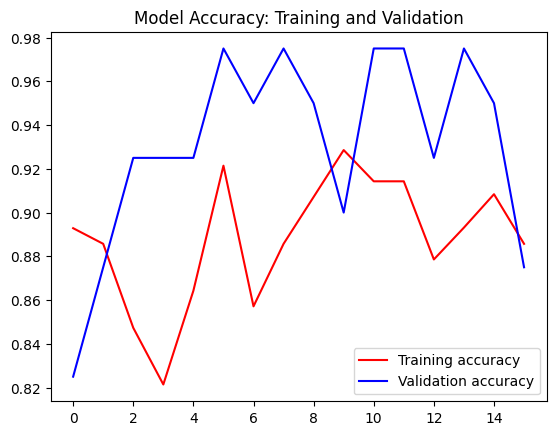

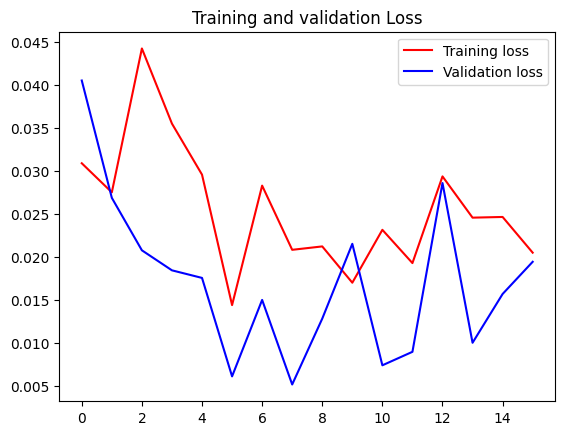

<Figure size 640x480 with 0 Axes>

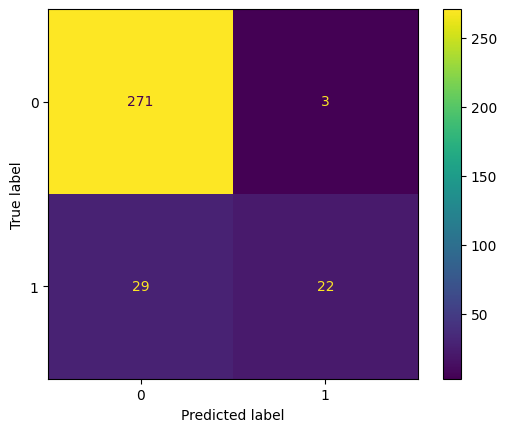


               precision    recall  f1-score   support

           0       0.90      0.99      0.94       274
           1       0.88      0.43      0.58        51

    accuracy                           0.90       325
   macro avg       0.89      0.71      0.76       325
weighted avg       0.90      0.90      0.89       325

Sensitivity: 0.431 Specificity: 0.989 Precision: 0.9 ROC_AUC_SCORE: 0.916



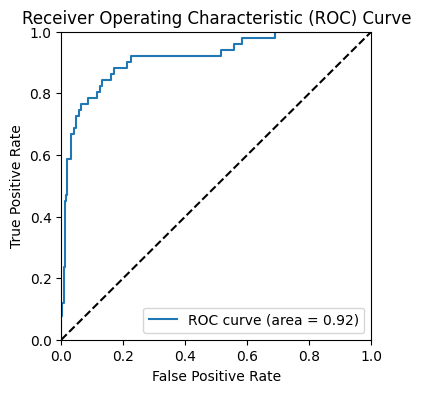

Validation complete...
Traning for Fold: 3
Found 1301 validated image filenames belonging to 2 classes.
Found 325 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.8714
Epoch 1: val_accuracy improved from -inf to 0.95000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_3.hdf5
14/14 [==============================] - 61s 874ms/step - loss: 0.0312 - accuracy: 0.8714 - val_loss: 0.0085 - val_accuracy: 0.9500 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9214
Epoch 2: val_accuracy did not improve from 0.95000
14/14 [==============================] - 8s 553ms/step - loss: 0.0271 - accuracy: 0.9214 - val_loss: 0.0152 - val_accuracy: 0.9250 - lr: 2.0000e-05

Epoch 3: LearningRateSche

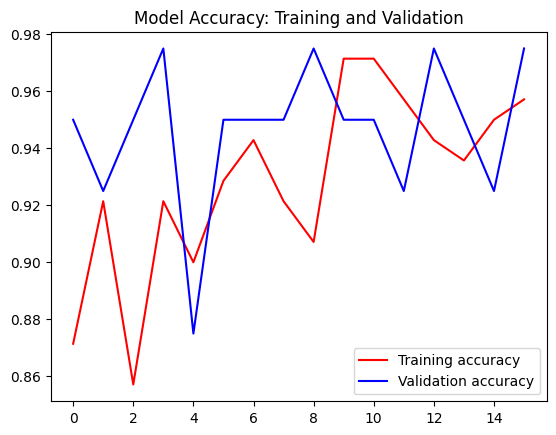

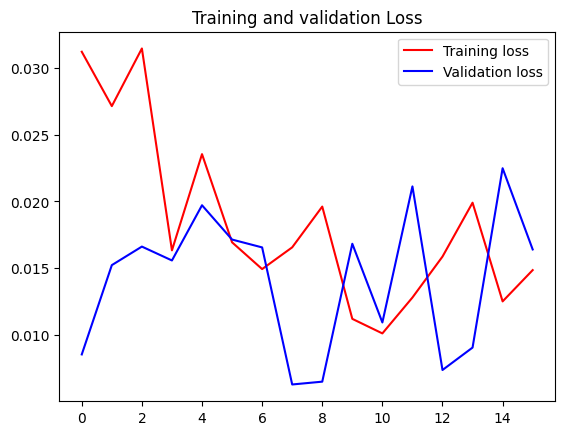

<Figure size 640x480 with 0 Axes>

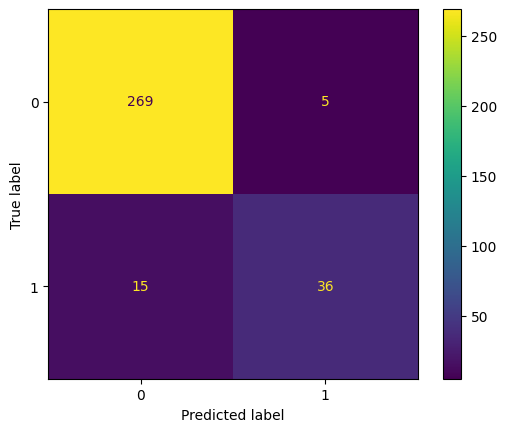


               precision    recall  f1-score   support

           0       0.95      0.98      0.96       274
           1       0.88      0.71      0.78        51

    accuracy                           0.94       325
   macro avg       0.91      0.84      0.87       325
weighted avg       0.94      0.94      0.94       325

Sensitivity: 0.706 Specificity: 0.982 Precision: 0.936 ROC_AUC_SCORE: 0.961



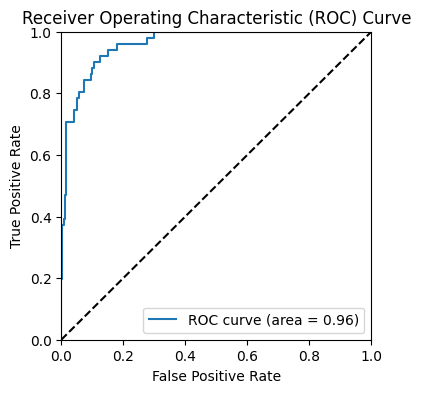

Validation complete...
Traning for Fold: 4
Found 1301 validated image filenames belonging to 2 classes.
Found 325 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.8857
Epoch 1: val_accuracy improved from -inf to 0.92500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_4.hdf5
14/14 [==============================] - 60s 820ms/step - loss: 0.0254 - accuracy: 0.8857 - val_loss: 0.0246 - val_accuracy: 0.9250 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.0261 - accuracy: 0.8714
Epoch 2: val_accuracy did not improve from 0.92500
14/14 [==============================] - 8s 530ms/step - loss: 0.0261 - accuracy: 0.8714 - val_loss: 0.0154 - val_accuracy: 0.9250 - lr: 2.0000e-05

Epoch 3: LearningRateSche

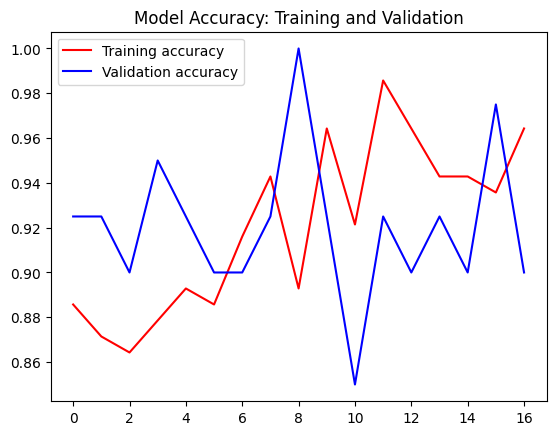

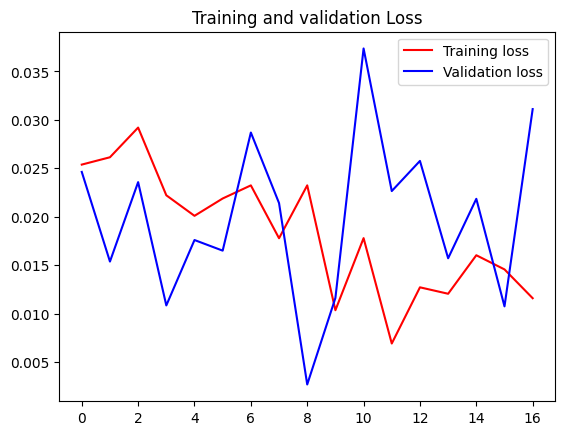

<Figure size 640x480 with 0 Axes>

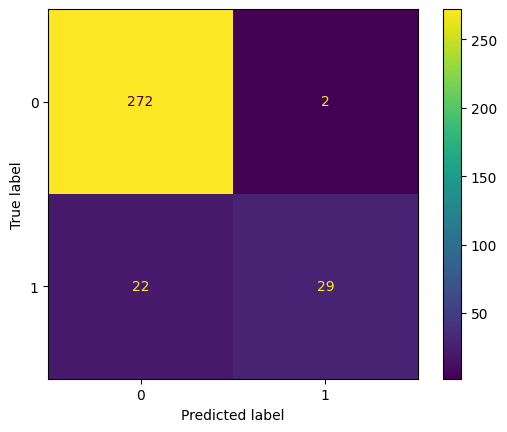


               precision    recall  f1-score   support

           0       0.93      0.99      0.96       274
           1       0.94      0.57      0.71        51

    accuracy                           0.93       325
   macro avg       0.93      0.78      0.83       325
weighted avg       0.93      0.93      0.92       325

Sensitivity: 0.569 Specificity: 0.993 Precision: 0.927 ROC_AUC_SCORE: 0.963



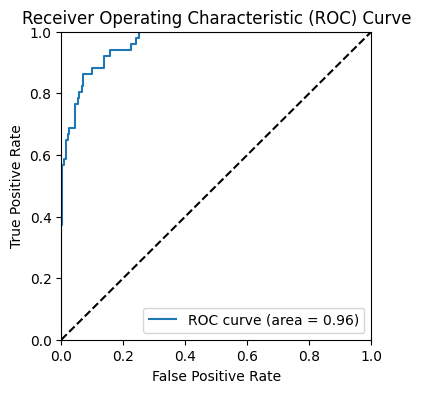

Validation complete...
Traning for Fold: 5
Found 1301 validated image filenames belonging to 2 classes.
Found 325 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9571
Epoch 1: val_accuracy improved from -inf to 0.92500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_5.hdf5
14/14 [==============================] - 63s 913ms/step - loss: 0.0135 - accuracy: 0.9571 - val_loss: 0.0275 - val_accuracy: 0.9250 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9571
Epoch 2: val_accuracy improved from 0.92500 to 0.97500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_5.hdf5
14/14 [==============================] - 14s 1s/step - loss: 0.0150 - accura

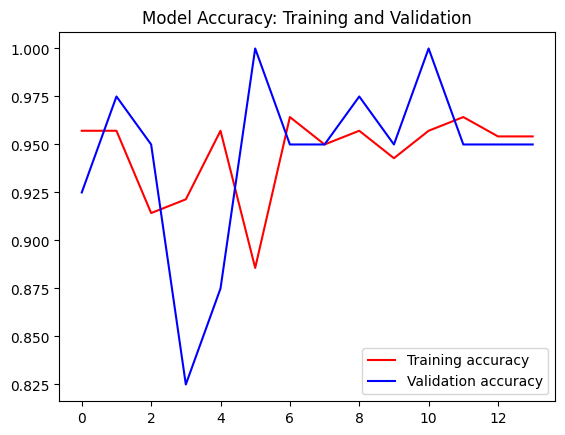

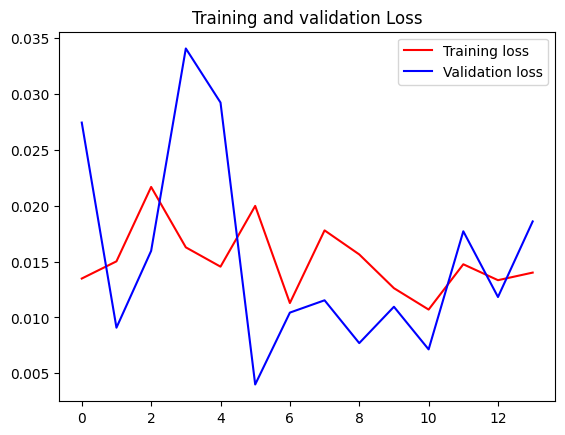

<Figure size 640x480 with 0 Axes>

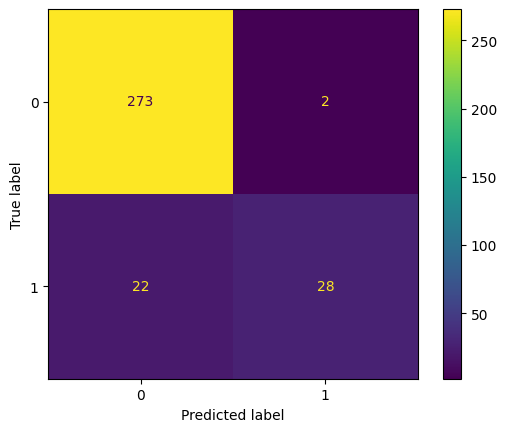


               precision    recall  f1-score   support

           0       0.93      0.99      0.96       275
           1       0.93      0.56      0.70        50

    accuracy                           0.93       325
   macro avg       0.93      0.78      0.83       325
weighted avg       0.93      0.93      0.92       325

Sensitivity: 0.56 Specificity: 0.993 Precision: 0.927 ROC_AUC_SCORE: 0.981



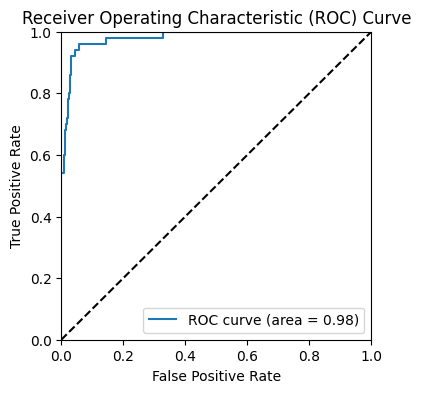

Validation complete...


In [ ]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
#     print(f"Fold {i}:")
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
      pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
      directory=train_dir,
      x_col='filename',
      y_col='class',
      target_size=image_size,
      batch_size=batch
  )

    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    # Compile the model
    model.compile(
        optimizer='adam',
        loss=focal_loss(),
        metrics=['accuracy']
    )

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=30,
        callbacks=callbacks)

    graph_it(history)


    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


**Model Evaluation using test data**

In [ ]:
test_dir

'/content/drive/MyDrive/msc_project/test_splited'

In [ ]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )
test_generator.shuffle = False

Found 483 images belonging to 2 classes.


Test using model 1
483/483 [==============================] - 23s 47ms/step


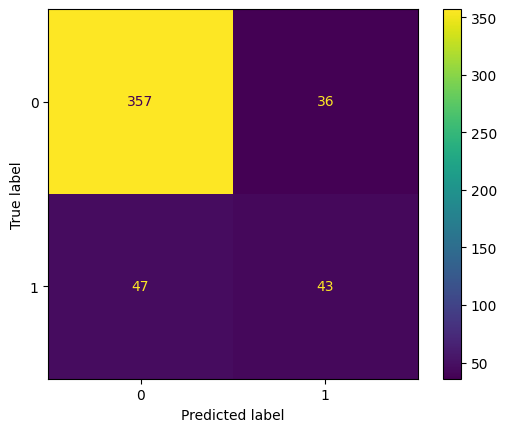


               precision    recall  f1-score   support

           0       0.88      0.91      0.90       393
           1       0.54      0.48      0.51        90

    accuracy                           0.83       483
   macro avg       0.71      0.69      0.70       483
weighted avg       0.82      0.83      0.82       483

Sensitivity: 0.478 Specificity: 0.908 Precision: 0.82 ROC_AUC_SCORE: 0.845



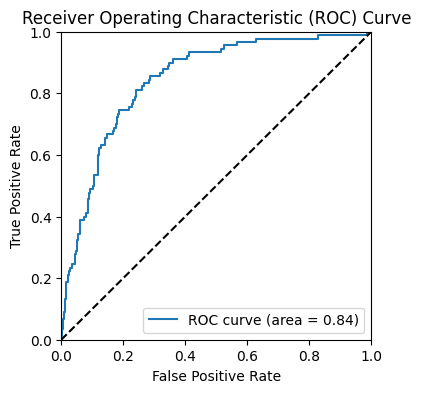

Testing Complete
Test using model 2
483/483 [==============================] - 22s 46ms/step


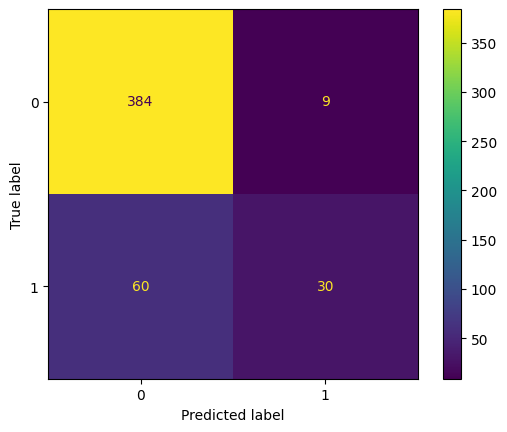


               precision    recall  f1-score   support

           0       0.86      0.98      0.92       393
           1       0.77      0.33      0.47        90

    accuracy                           0.86       483
   macro avg       0.82      0.66      0.69       483
weighted avg       0.85      0.86      0.83       483

Sensitivity: 0.333 Specificity: 0.977 Precision: 0.847 ROC_AUC_SCORE: 0.903



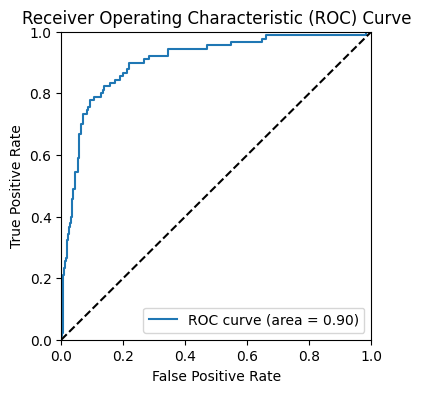

Testing Complete
Test using model 3
483/483 [==============================] - 22s 46ms/step


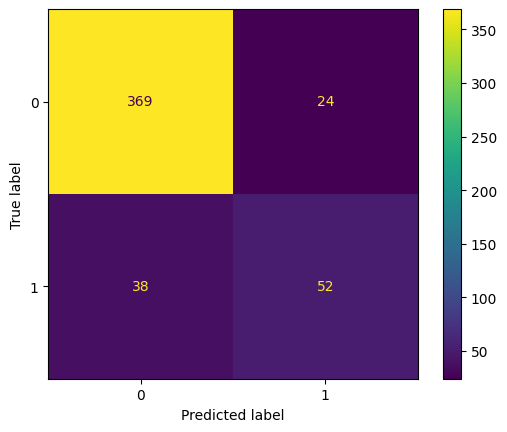


               precision    recall  f1-score   support

           0       0.91      0.94      0.92       393
           1       0.68      0.58      0.63        90

    accuracy                           0.87       483
   macro avg       0.80      0.76      0.77       483
weighted avg       0.87      0.87      0.87       483

Sensitivity: 0.578 Specificity: 0.939 Precision: 0.865 ROC_AUC_SCORE: 0.879



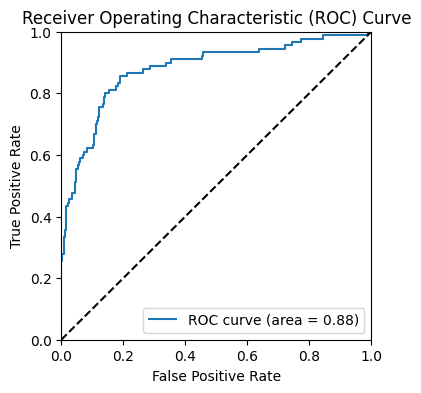

Testing Complete
Test using model 4
483/483 [==============================] - 21s 44ms/step


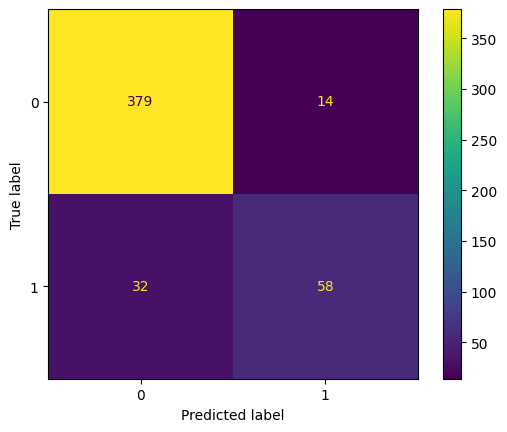


               precision    recall  f1-score   support

           0       0.92      0.96      0.94       393
           1       0.81      0.64      0.72        90

    accuracy                           0.90       483
   macro avg       0.86      0.80      0.83       483
weighted avg       0.90      0.90      0.90       483

Sensitivity: 0.644 Specificity: 0.964 Precision: 0.9 ROC_AUC_SCORE: 0.923



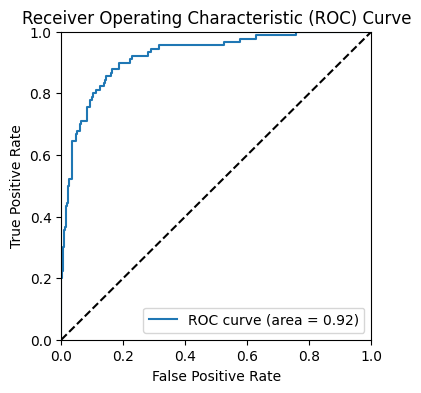

Testing Complete


In [ ]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")

# WE DON'T NEED THIS PART ANYMORE

600/600 [==============================] - 32s 45ms/step


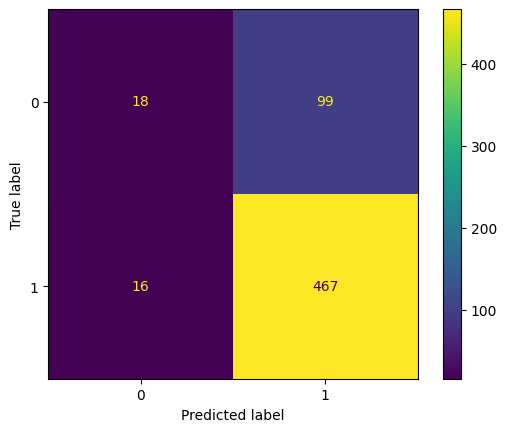


               precision    recall  f1-score   support

           0       0.53      0.15      0.24       117
           1       0.83      0.97      0.89       483

    accuracy                           0.81       600
   macro avg       0.68      0.56      0.56       600
weighted avg       0.77      0.81      0.76       600

Sensitivity: 0.967 Specificity: 0.154 Precision: 0.767 ROC_AUC_SCORE: 0.701



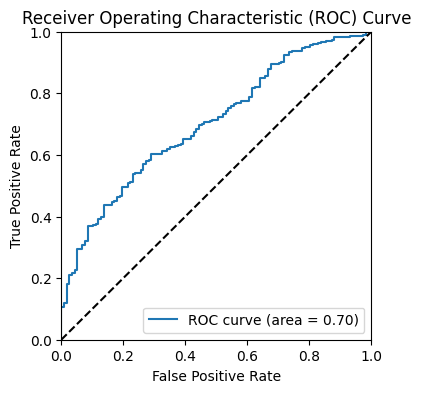

In [ ]:
model.load_weights(filepath = f'/content/drive/MyDrive/msc_project/model/model1.hdf5')

test_it(model, test_generator)

Model 2

600/600 [==============================] - 28s 47ms/step


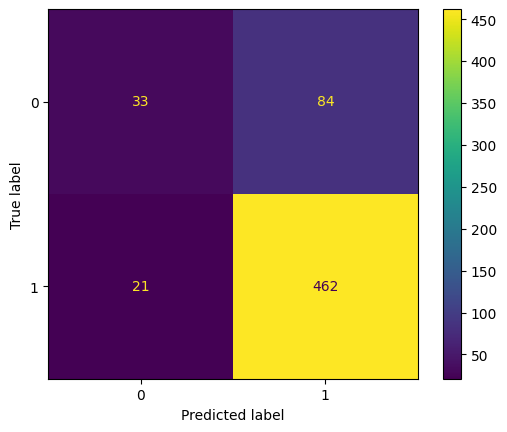


               precision    recall  f1-score   support

           0       0.61      0.28      0.39       117
           1       0.85      0.96      0.90       483

    accuracy                           0.82       600
   macro avg       0.73      0.62      0.64       600
weighted avg       0.80      0.82      0.80       600

Sensitivity: 0.957 Specificity: 0.282 Precision: 0.8 ROC_AUC_SCORE: 0.787



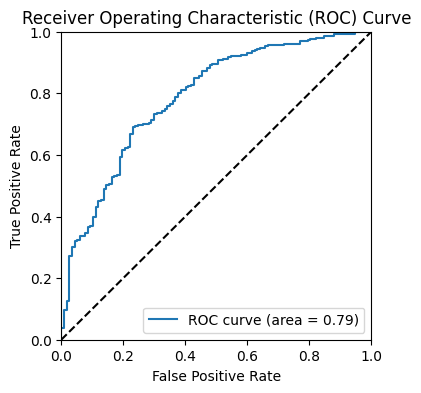

In [ ]:
model.load_weights(filepath = f'/content/drive/MyDrive/msc_project/model/model2.hdf5')
test_it(model, test_generator)

Model 3

600/600 [==============================] - 28s 46ms/step


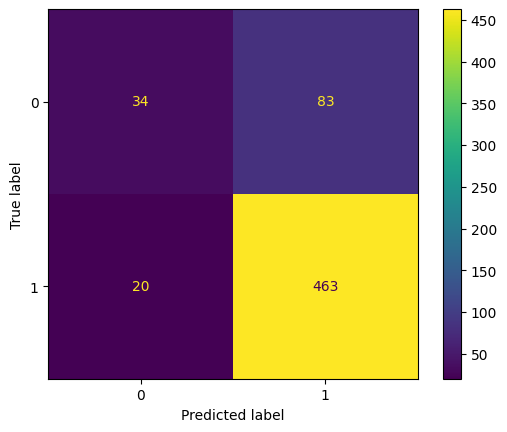


               precision    recall  f1-score   support

           0       0.63      0.29      0.40       117
           1       0.85      0.96      0.90       483

    accuracy                           0.83       600
   macro avg       0.74      0.62      0.65       600
weighted avg       0.81      0.83      0.80       600

Sensitivity: 0.959 Specificity: 0.291 Precision: 0.805 ROC_AUC_SCORE: 0.788



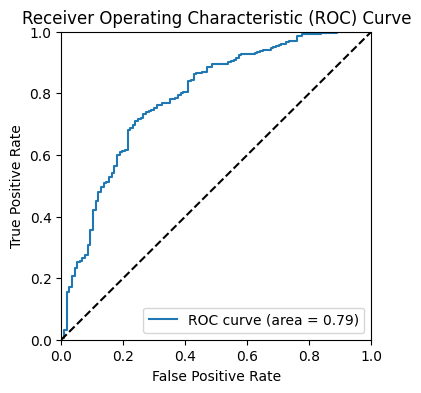

In [ ]:
model.load_weights(filepath = f'/content/drive/MyDrive/msc_project/model/model3.hdf5')
test_it(model, test_generator)


Model 4

600/600 [==============================] - 27s 45ms/step


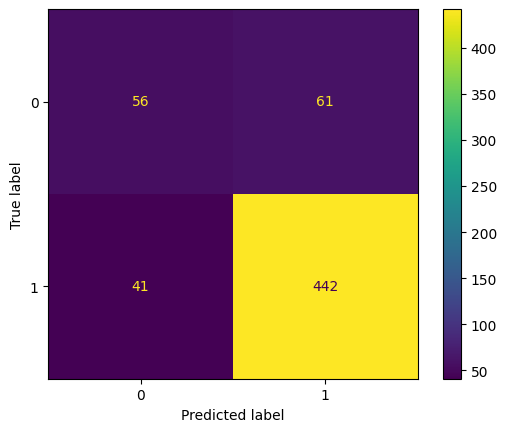


               precision    recall  f1-score   support

           0       0.58      0.48      0.52       117
           1       0.88      0.92      0.90       483

    accuracy                           0.83       600
   macro avg       0.73      0.70      0.71       600
weighted avg       0.82      0.83      0.82       600

Sensitivity: 0.915 Specificity: 0.479 Precision: 0.82 ROC_AUC_SCORE: 0.806



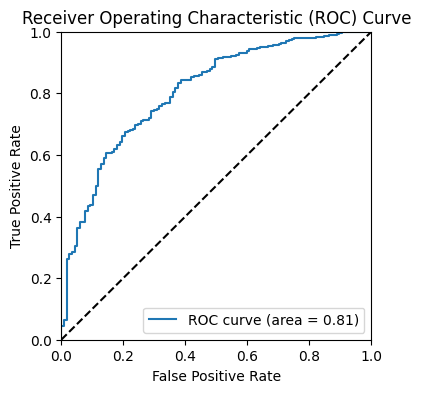

In [ ]:
model.load_weights(filepath = f'/content/drive/MyDrive/msc_project/model/model4.hdf5')
test_it(model, test_generator)

Model 5

600/600 [==============================] - 27s 44ms/step


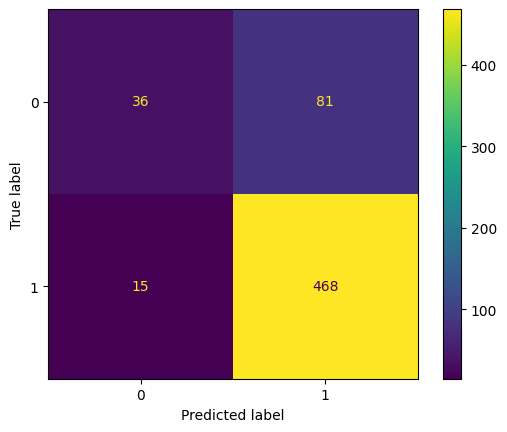


               precision    recall  f1-score   support

           0       0.71      0.31      0.43       117
           1       0.85      0.97      0.91       483

    accuracy                           0.84       600
   macro avg       0.78      0.64      0.67       600
weighted avg       0.82      0.84      0.81       600

Sensitivity: 0.969 Specificity: 0.308 Precision: 0.824 ROC_AUC_SCORE: 0.808



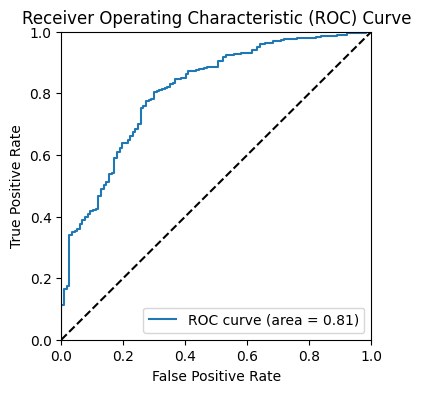

In [ ]:
model.load_weights(filepath = f'/content/drive/MyDrive/msc_project/model/model5.hdf5')
test_it(model, test_generator)